In [382]:
import os
import glob
from datetime import datetime
from datetime import timezone
import polars as pl
import plotly.express as px

start_date = datetime(2023, 11, 17, 0, 0, 0).replace(tzinfo=timezone.utc)
end_date = datetime(2023, 11, 29, 0, 0, 0).replace(tzinfo=timezone.utc)
id_system = 11

DATA_DIRECTORY = os.environ.get("DATA_DIRECTORY")
PICARRO_DATA_DIRECTORy = os.environ.get("PICARRO_DATA_DIRECTORY")

df_cal = pl.scan_parquet(os.path.join(DATA_DIRECTORY, "processed", "slope_intercept_acropolis.parquet"))

In [383]:
df_cal = df_cal.with_columns((pl.col("creation_timestamp").dt.timestamp("ms") / 3.6e6).alias("timestamp")) #3.6e6 ms are in 1h

#df_cal = df_cal.with_columns((pl.col("creation_timestamp").dt.timestamp().cast(pl.Float64)).alias("timestamp"))

In [384]:
df_sys = df_cal.filter(pl.col("system_name") == f"tum-esm-midcost-raspi-{id_system}").filter(pl.col("creation_timestamp").is_between(start_date, end_date))

In [385]:
fig = px.line(df_sys.collect(), x="date", y=f"slope", markers=True, title = "Slope")
fig.show()

fig = px.line(df_sys.collect(), x="date", y=f"intercept", markers=True, title = "Slope")
fig.show()

# Define slope and intercept over time with linear regression

R-squared: 0.000107


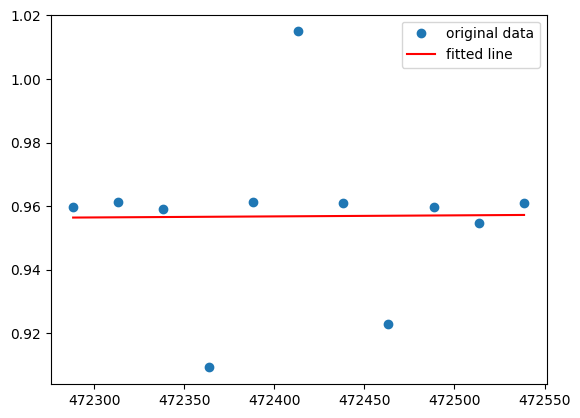

In [386]:
import numpy as np
from scipy import stats

y = df_sys.select(pl.col("slope")).collect().to_series().to_list()
x = df_sys.select(pl.col("timestamp")).collect().to_series().to_list()

x = np.array(x)
#x = range(len(y))

res = stats.linregress(x, y)

print(f"R-squared: {res.rvalue**2:.6f}")

import matplotlib.pyplot as plt
plt.plot(x, y, 'o', label='original data')
plt.plot(x, res.intercept + res.slope*x, 'r', label='fitted line')
plt.legend()
plt.show()

R-squared: 0.000946


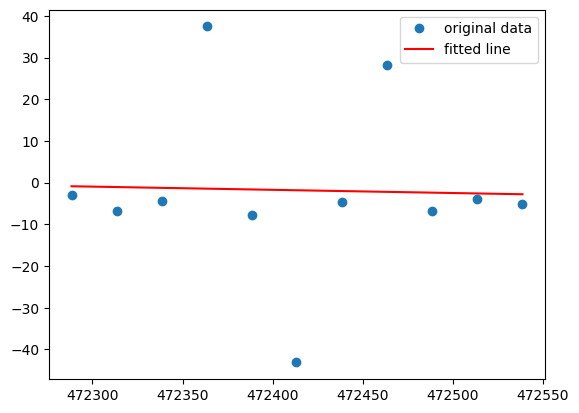

In [387]:
import numpy as np
from scipy import stats

y = df_sys.select(pl.col("intercept")).collect().to_series().to_list()
x = df_sys.select(pl.col("timestamp")).collect().to_series().to_list()

x = np.array(x)
#x = range(len(y))

res = stats.linregress(x, y)

print(f"R-squared: {res.rvalue**2:.6f}")

import matplotlib.pyplot as plt
plt.plot(x, y, 'o', label='original data')
plt.plot(x, res.intercept + res.slope*x, 'r', label='fitted line')
plt.legend()
plt.show()

# Use RANSAC algortihm

Estimated coefficients (true, linear regression, RANSAC):
[3.27024743e-06] [4.4240026e-07]
[ True  True False False  True False  True False  True False  True]


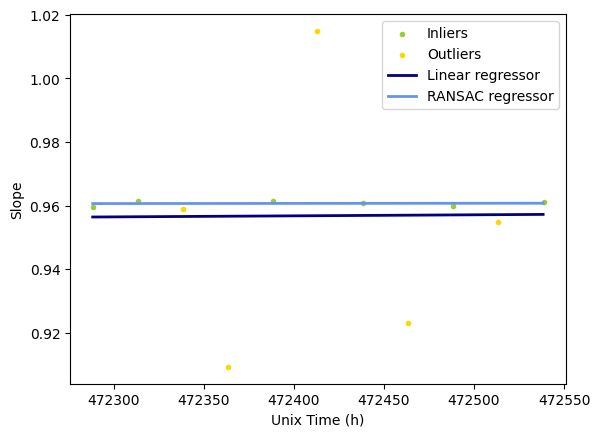

In [388]:
from sklearn import linear_model
import numpy as np

# ---- init ----

df_sys = df_cal.filter(pl.col("system_name") == f"tum-esm-midcost-raspi-{id_system}").filter(pl.col("creation_timestamp").is_between(start_date, end_date))

y = df_sys.select(pl.col("slope")).collect().to_series().to_list()
x = df_sys.select(pl.col("timestamp")).collect().to_series().to_list()

#x = range(len(y))

Y = np.array(y)
X = np.array(x)

# --------------

lr = linear_model.LinearRegression()
lr.fit(X.reshape(-1, 1), Y)


# Robustly fit linear model with RANSAC algorithm
ransac_slope = linear_model.RANSACRegressor()
ransac_slope.fit(X.reshape(-1, 1), Y)
inlier_mask = ransac_slope.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)

# Predict data of estimated models
line_X = np.arange(X.min(), X.max())[:, np.newaxis]
line_y = lr.predict(line_X)
line_y_ransac = ransac_slope.predict(line_X)

# Compare estimated coefficients
print("Estimated coefficients (true, linear regression, RANSAC):")
print(lr.coef_, ransac_slope.estimator_.coef_)
print(inlier_mask)

lw = 2
#plt.gca().invert_yaxis() # Mirror points 

plt.scatter(
    X[inlier_mask], Y[inlier_mask], color="yellowgreen", marker=".", label="Inliers"
)
plt.scatter(
    X[outlier_mask], Y[outlier_mask], color="gold", marker=".", label="Outliers"
)
plt.plot(line_X, line_y, color="navy", linewidth=lw, label="Linear regressor")
plt.plot(
    line_X,
    line_y_ransac,
    color="cornflowerblue",
    linewidth=lw,
    label="RANSAC regressor",
)
plt.legend()
plt.xlabel("Unix Time (h)")
plt.ylabel("Slope")
plt.show()

Estimated coefficients (true, linear regression, RANSAC):
[-0.00766576] [0.01066021]
[False  True False False  True False  True False  True  True  True]


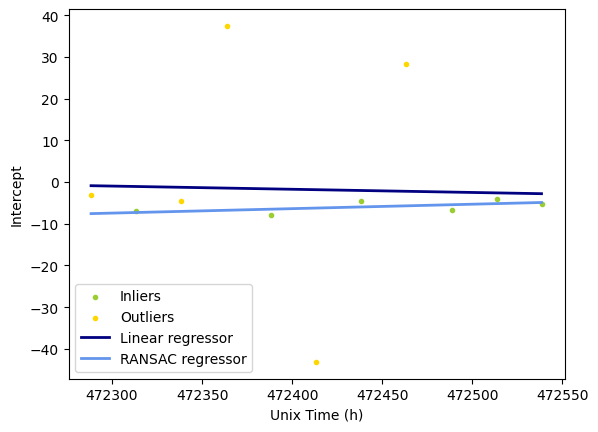

In [389]:
from sklearn import linear_model, datasets
import numpy as np

# ---- init ----

df_sys = df_cal.filter(pl.col("system_name") == f"tum-esm-midcost-raspi-{id_system}").filter(pl.col("creation_timestamp").is_between(start_date, end_date))

y = df_sys.select(pl.col("intercept")).collect().to_series().to_list()
x = df_sys.select(pl.col("timestamp")).collect().to_series().to_list()

Y = np.array(y)
X = np.array(x)

# --------------

lr = linear_model.LinearRegression()
lr.fit(X.reshape(-1, 1), Y)


# Robustly fit linear model with RANSAC algorithm
ransac_intercept = linear_model.RANSACRegressor()
ransac_intercept.fit(X.reshape(-1, 1), Y)
inlier_mask = ransac_intercept.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)

# Predict data of estimated models
line_X = np.arange(X.min(), X.max())[:, np.newaxis]
line_y = lr.predict(line_X)
line_y_ransac = ransac_intercept.predict(line_X)

# Compare estimated coefficients
print("Estimated coefficients (true, linear regression, RANSAC):")
print(lr.coef_, ransac_intercept.estimator_.coef_)
print(inlier_mask)

lw = 2
#plt.gca().invert_yaxis() # Mirror points 

plt.scatter(
    X[inlier_mask], Y[inlier_mask], color="yellowgreen", marker=".", label="Inliers"
)
plt.scatter(
    X[outlier_mask], Y[outlier_mask], color="gold", marker=".", label="Outliers"
)
plt.plot(line_X, line_y, color="navy", linewidth=lw, label="Linear regressor")
plt.plot(
    line_X,
    line_y_ransac,
    color="cornflowerblue",
    linewidth=lw,
    label="RANSAC regressor",
)
plt.legend()
plt.xlabel("Unix Time (h)")
plt.ylabel("Intercept")
plt.show()

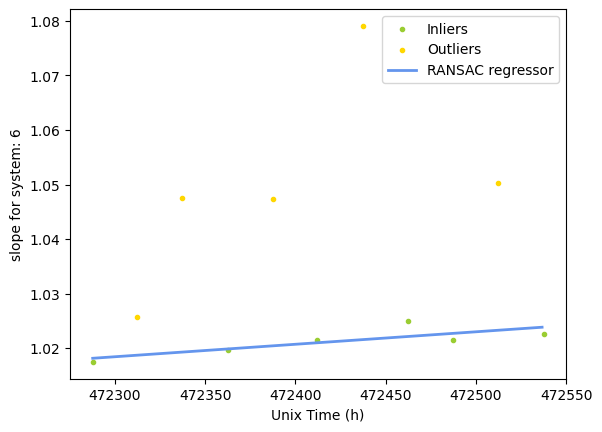

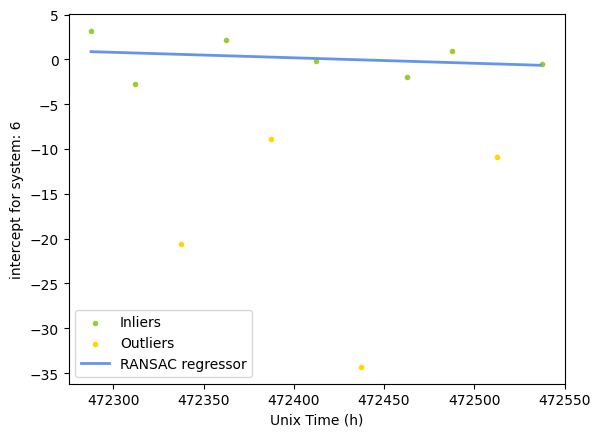

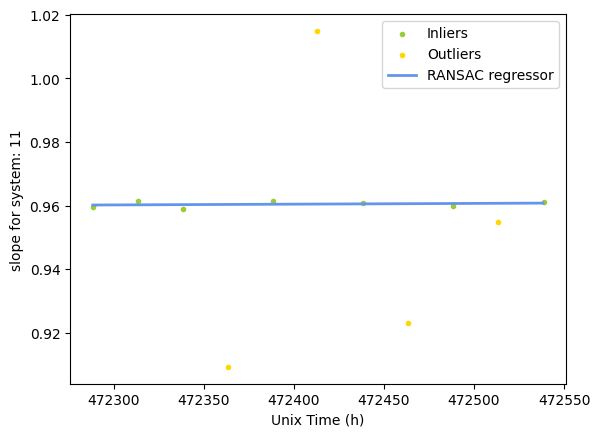

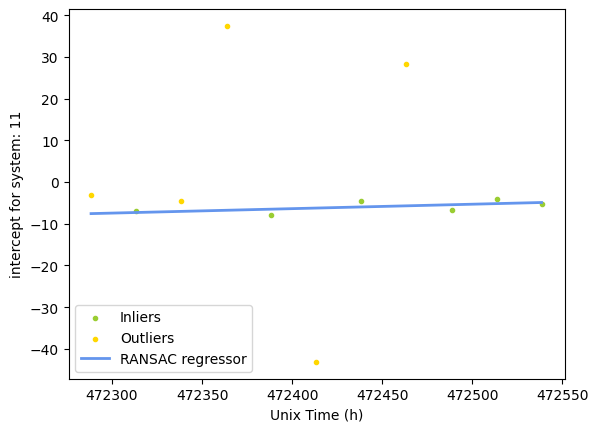

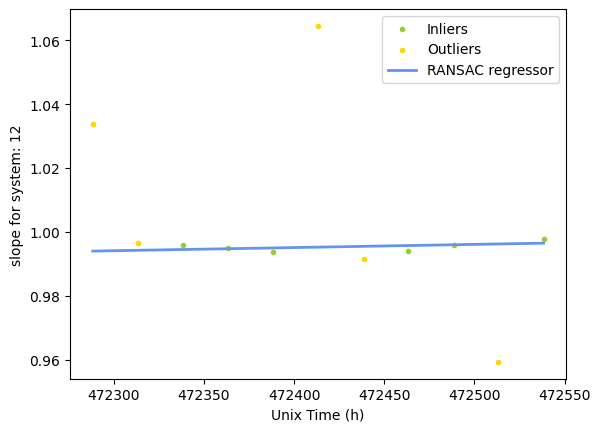

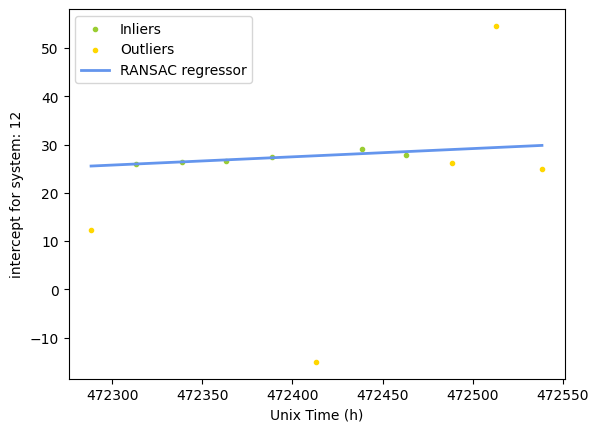

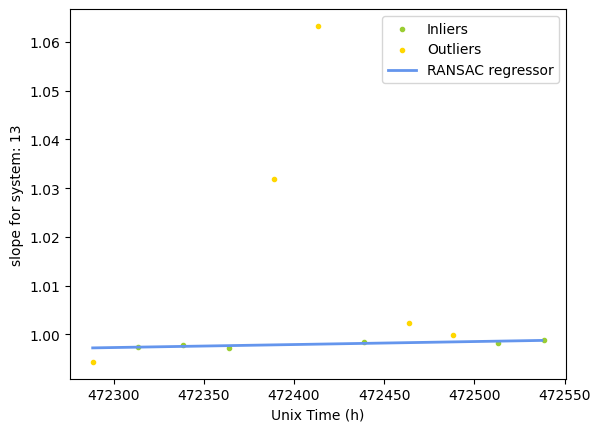

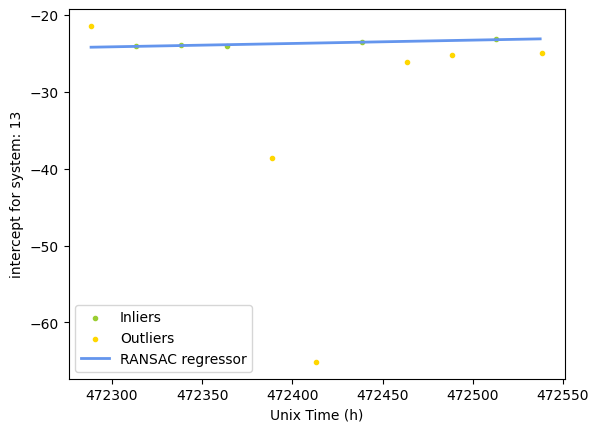

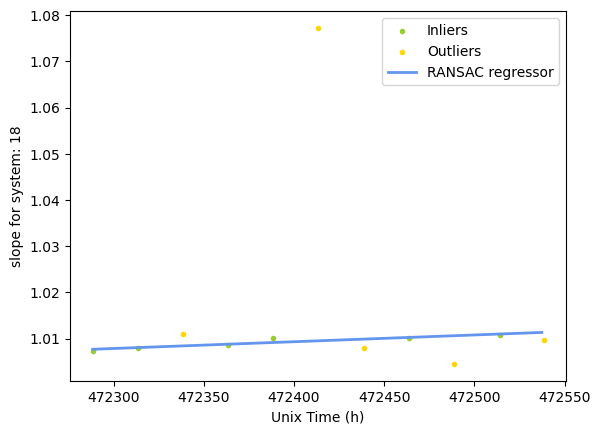

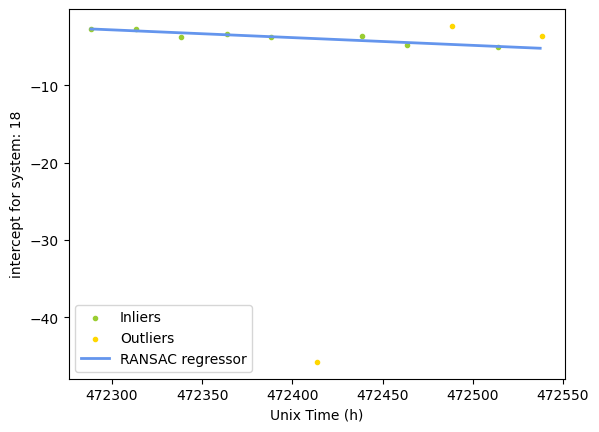

In [390]:
sensor_id = [6,11,12,13,18]

df_p_1h = pl.read_parquet(os.path.join(DATA_DIRECTORY,"processed", "1h_cal_corr_picarro.parquet")) \
    .filter(pl.col("creation_timestamp").is_between(start_date, end_date))

df_dry = pl.scan_parquet(os.path.join(DATA_DIRECTORY, "processed", "acropolis_dry.parquet")).filter(pl.col("creation_timestamp").is_between(start_date, end_date))

def calc_ransac(x, ransac):
    intercept = ransac.estimator_.intercept_
    slope = ransac.estimator_.coef_
    
    x = (x * slope) + intercept
    
    return x[0]

def fit_ransac(id_system, col):
    
    df_sys = df_cal.filter(pl.col("system_name") == f"tum-esm-midcost-raspi-{id_system}").filter(pl.col("creation_timestamp").is_between(start_date, end_date))

    y = df_sys.select(pl.col(col)).collect().to_series().to_list()
    x = df_sys.select(pl.col("timestamp")).collect().to_series().to_list()

    #x = range(len(y))

    Y = np.array(y)
    X = np.array(x)

    # Robustly fit linear model with RANSAC algorithm
    ransac = linear_model.RANSACRegressor()
    ransac.fit(X.reshape(-1, 1), Y)
    inlier_mask = ransac.inlier_mask_
    outlier_mask = np.logical_not(inlier_mask)
    line_X = np.arange(X.min(), X.max())[:, np.newaxis]
    line_y_ransac = ransac.predict(line_X)
    
    lw = 2
    

    plt.scatter(
        X[inlier_mask], Y[inlier_mask], color="yellowgreen", marker=".", label="Inliers"
    )
    plt.scatter(
        X[outlier_mask], Y[outlier_mask], color="gold", marker=".", label="Outliers"
    )
    plt.plot(
        line_X,
        line_y_ransac,
        color="cornflowerblue",
        linewidth=lw,
        label="RANSAC regressor",
    )
    plt.legend()
    plt.xlabel("Unix Time (h)")
    plt.ylabel(f"{col} for system: {id}")
    plt.show()
    
    return ransac


l_df_cal_corr =[df_p_1h]
    

for id in sensor_id:  
    ransac_slope = fit_ransac(id, "slope")
    ransac_intercept = fit_ransac(id, "intercept")
    
    df_cal_corr = df_dry.filter(pl.col("system_name") == f"tum-esm-midcost-raspi-{id}") \
        .with_columns((pl.col("creation_timestamp").dt.timestamp("ms") / 3.6e6).alias("unix_time_h")) \
        .with_columns((pl.col("unix_time_h").apply(lambda x: calc_ransac(x, ransac_slope))).alias("slope")) \
        .with_columns((pl.col("unix_time_h").apply(lambda x: calc_ransac(x, ransac_intercept))).alias("intercept")) \
        .with_columns((pl.col("gmp343_dry") * pl.col("slope") + pl.col("intercept")).alias("CO2_corr")) \
        .sort("creation_timestamp") \
        .select(["creation_timestamp", "system_name", "CO2_corr"]) \
        .groupby_dynamic("creation_timestamp", every='1h')  \
        .agg([
            pl.all().exclude(["creation_timestamp","system_name"]).mean(),
            pl.col("system_name")
            ]) \
        .with_columns(pl.col("system_name").list.last()) \
        .collect()
        
    df_cal_corr = df_cal_corr.join(df_p_1h.select("creation_timestamp", "CO2_corr") \
            .rename({"CO2_corr": "temp"}), on="creation_timestamp", how= "left") \
            .with_columns((pl.col("CO2_corr") - pl.col("temp")).alias("diff")) \
            .drop("temp")
        
    l_df_cal_corr.append(df_cal_corr)

In [391]:
df_cal_cor = pl.concat(l_df_cal_corr, how="diagonal")

In [392]:
import plotly.express as px

fig = px.line(df_cal_cor, x="creation_timestamp", y=f"CO2_corr", markers=True, title = "CO2", color="system_name")
fig.show()

fig = px.line(df_cal_cor, x="creation_timestamp", y=f"diff", markers=True, title = "CO2", color="system_name")
fig.show()

In [393]:
import math
from sklearn.metrics import r2_score

def rmse(y_true, y_meas):
    MSE = np.square(np.subtract(y_true, y_meas)).mean()
    RMSE = math.sqrt(MSE)

    return RMSE

def calc_r2(y_true, y_meas):
    return r2_score(y_true, y_meas)


for temp_id in sensor_id:

    print(f"\nAnalysis for System {temp_id}:")

    #----
    df_acropolis = df_cal_cor.filter(pl.col("system_name")==f"tum-esm-midcost-raspi-{temp_id}") \
        .select(["creation_timestamp", "CO2_corr"]) \
        .rename({"CO2_corr": f"CO2_acropolis_{temp_id}"})
        
    df_picarro = df_cal_cor.filter(pl.col("system_name")=="Picarro") \
        .select(["creation_timestamp", "CO2_corr"]) \
        .rename({"CO2_corr": f"CO2_picarro"})
        
    df_analysis = df_picarro.join(df_acropolis, on="creation_timestamp")  \
        .filter(pl.col("CO2_picarro") > 0)  \
        .filter(pl.col(f"CO2_acropolis_{temp_id}") > 0)
        
    l_picarro = df_analysis.select("CO2_picarro").to_series().to_list()
    l_acropolis = df_analysis.select(f"CO2_acropolis_{temp_id}").to_series().to_list()
    
    #----
    if len(l_acropolis) > 0:
        
        mean_offset = df_cal_cor.filter(pl.col("system_name")==f"tum-esm-midcost-raspi-{temp_id}").select("diff").mean().item()
        print(f"Offset {mean_offset}")
        
        rmse_result = rmse(l_picarro,l_acropolis)
        print(f"RMSE: {rmse_result}")
        
        r2_result = calc_r2(l_picarro,l_acropolis)
        print(f"R2: {r2_result}")


Analysis for System 6:
Offset -0.4346396962073025
RMSE: 3.262343142682238
R2: 0.8712884146085973

Analysis for System 11:
Offset 7.662005413037948
RMSE: 7.822171093458206
R2: 0.2600319254214949

Analysis for System 12:
Offset 12.43515960896903
RMSE: 12.537072185042407
R2: -0.9008621086581452

Analysis for System 13:
Offset 0.1754314545518651
RMSE: 1.0685262348111382
R2: 0.986192064809505

Analysis for System 18:
Offset 1.0592543537240118
RMSE: 1.2445511700999912
R2: 0.9812680117914664


In [394]:
for temp_id in sensor_id:

    print(f"\nAnalysis for System {temp_id}:")

    #----
    mean_offset = 0
    if len(l_acropolis) > 0:
        mean_offset = df_cal_cor.filter(pl.col("system_name")==f"tum-esm-midcost-raspi-{temp_id}").select("diff").mean().item()
    
    df_acropolis = df_cal_cor.filter(pl.col("system_name")==f"tum-esm-midcost-raspi-{temp_id}") \
        .select(["creation_timestamp", "CO2_corr"]) \
        .with_columns(pl.col("CO2_corr") - mean_offset)  \
        .rename({"CO2_corr": f"CO2_acropolis_{temp_id}"})
        
    df_picarro = df_cal_cor.filter(pl.col("system_name")=="Picarro") \
        .select(["creation_timestamp", "CO2_corr"]) \
        .rename({"CO2_corr": f"CO2_picarro"})
        
    df_analysis = df_picarro.join(df_acropolis, on="creation_timestamp")  \
        .filter(pl.col("CO2_picarro") > 0)  \
        .filter(pl.col(f"CO2_acropolis_{temp_id}") > 0)
        
    l_picarro = df_analysis.select("CO2_picarro").to_series().to_list()
    l_acropolis = df_analysis.select(f"CO2_acropolis_{temp_id}").to_series().to_list()
    
    #----
    if len(l_acropolis) > 0:
        
        rmse_result = rmse(l_picarro,l_acropolis)
        print(f"RMSE: {rmse_result}")
        
        r2_result = calc_r2(l_picarro,l_acropolis)
        print(f"R2: {r2_result}")


Analysis for System 6:
RMSE: 3.2332601372433123
R2: 0.8735730512497347

Analysis for System 11:
RMSE: 1.5748122637033033
R2: 0.970007274199707

Analysis for System 12:
RMSE: 1.5953007467023934
R2: 0.9692217801327488

Analysis for System 13:
RMSE: 1.0540266216910674
R2: 0.9865642621703244

Analysis for System 18:
RMSE: 0.6533665350429138
R2: 0.9948373565318525
